In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

import phenom

import lal
import lalsimulation as lalsim

import lalutils

In [2]:
import surrogate
import greedyrb
import gprfit
import george

# data acquisition

We need a function that we can call to
generate data in a uniform way.

We will use this to generate the data for:
 - the seed basis
 - additional training sets and
 - validation sets

In [85]:
def gen_2d_massratio_data(q_array, chi_array, M, deltaF=1/8., f_min=30, f_max=200,
                         approximant=lalsim.IMRPhenomD, inclination=0):

    data = []
    coords = []
    
    for q, chi in zip(q_array, chi_array):
        m1, m2 = phenom.m1_m2_M_q(M, q)
        pp = dict(m1=m1, m2=m2, deltaF=deltaF,
                  f_min=f_min, f_max=f_max,
                  inclination=inclination,
                  S1z=chi,
                  approximant=approximant
                 )
        p = lalutils.gen_wf_params(**pp)
        f, _, _, phase = lalutils.gen_wf(p)
        d = {"f":f, "phase":phase}
#         f, _, amp, phase = lalutils.gen_wf(p)
#         d = {"f":f, "phase":phase, "amp":amp}
        data.append(d)
        coords.append([q, chi])
    
    new_f = []
    new_y = []
    
    # subtract linear piece from phase
    for i in range(len(data)):
        
        f = data[i]['f']
        y = data[i]['phase']
#         y = data[i]['amp']
        
#         mask = (f >= f_min) & (f <= f_max)
        mask = (f >= f_min) & (f <= f_max)

        z = np.polyfit(f[mask], y[mask], 1)
        p = np.poly1d(z)

        new_f.append(f)
        new_y.append(y - p(f))
#         new_f.append(f)
#         new_y.append(y)


    n_f_points = len(new_f[0])
    n_waveforms = len(new_f)
    ts = np.zeros(shape=(n_waveforms, n_f_points))
    
    x = new_f[0]
    for i in range(n_waveforms):
        ts[i] = new_y[i]
        
    return x, ts, np.array(coords)

In [268]:
qq, cc = np.meshgrid(np.linspace(1,10,7), np.linspace(-1,1,7))
qq = qq.ravel()
cc = cc.ravel()

In [269]:
qq

array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. ,  1. ,  2.5,  4. ,  5.5,
        7. ,  8.5, 10. ,  1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. ,  1. ,
        2.5,  4. ,  5.5,  7. ,  8.5, 10. ,  1. ,  2.5,  4. ,  5.5,  7. ,
        8.5, 10. ,  1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. ,  1. ,  2.5,
        4. ,  5.5,  7. ,  8.5, 10. ])

In [270]:
cc

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -0.66666667, -0.66666667, -0.66666667,
       -0.66666667, -0.66666667, -0.66666667, -0.66666667, -0.33333333,
       -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333,
       -0.33333333,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.33333333,  0.33333333,
        0.33333333,  0.33333333,  0.33333333,  0.33333333,  0.33333333,
        0.66666667,  0.66666667,  0.66666667,  0.66666667,  0.66666667,
        0.66666667,  0.66666667,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ])

In [271]:
seed_x, seed_ts, seed_ts_coords = gen_2d_massratio_data(qq, cc, 100)

In [272]:
seed_ts_coords

array([[ 1.        , -1.        ],
       [ 2.5       , -1.        ],
       [ 4.        , -1.        ],
       [ 5.5       , -1.        ],
       [ 7.        , -1.        ],
       [ 8.5       , -1.        ],
       [10.        , -1.        ],
       [ 1.        , -0.66666667],
       [ 2.5       , -0.66666667],
       [ 4.        , -0.66666667],
       [ 5.5       , -0.66666667],
       [ 7.        , -0.66666667],
       [ 8.5       , -0.66666667],
       [10.        , -0.66666667],
       [ 1.        , -0.33333333],
       [ 2.5       , -0.33333333],
       [ 4.        , -0.33333333],
       [ 5.5       , -0.33333333],
       [ 7.        , -0.33333333],
       [ 8.5       , -0.33333333],
       [10.        , -0.33333333],
       [ 1.        ,  0.        ],
       [ 2.5       ,  0.        ],
       [ 4.        ,  0.        ],
       [ 5.5       ,  0.        ],
       [ 7.        ,  0.        ],
       [ 8.5       ,  0.        ],
       [10.        ,  0.        ],
       [ 1.        ,

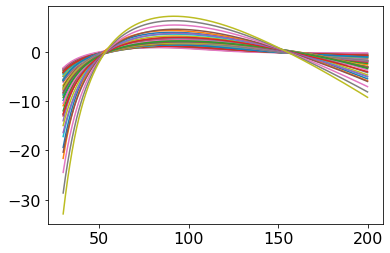

In [273]:
plt.figure()
for s in seed_ts:
    plt.plot(seed_x, s)
# plt.xscale('log')

# run

In [274]:
# Make integration rule

int_range = [seed_x[0], seed_x[-1]]
int_num = len(seed_x)

integration = greedyrb.Riemann(int_range, num=int_num)
x = integration.nodes  # Define x for convenience

In [275]:
sur = surrogate.Surrogate1D(integration)

In [276]:
sur.build_seed_basis(ts=seed_ts, ts_coords=seed_ts_coords)

building seed basis


In [277]:
sur.grb.greedy_points

array([[ 1.        , -1.        ],
       [ 2.5       , -1.        ],
       [ 4.        , -1.        ],
       [ 5.5       , -1.        ],
       [ 7.        , -1.        ],
       [ 8.5       , -1.        ],
       [10.        , -1.        ],
       [ 1.        , -0.66666667],
       [ 2.5       , -0.66666667],
       [ 4.        , -0.66666667],
       [ 5.5       , -0.66666667],
       [ 7.        , -0.66666667],
       [ 8.5       , -0.66666667],
       [10.        , -0.66666667],
       [ 1.        , -0.33333333],
       [ 2.5       , -0.33333333],
       [ 4.        , -0.33333333],
       [ 5.5       , -0.33333333],
       [ 7.        , -0.33333333],
       [ 8.5       , -0.33333333],
       [10.        , -0.33333333],
       [ 1.        ,  0.        ],
       [ 2.5       ,  0.        ],
       [ 4.        ,  0.        ],
       [ 5.5       ,  0.        ],
       [ 7.        ,  0.        ],
       [ 8.5       ,  0.        ],
       [10.        ,  0.        ],
       [ 1.        ,

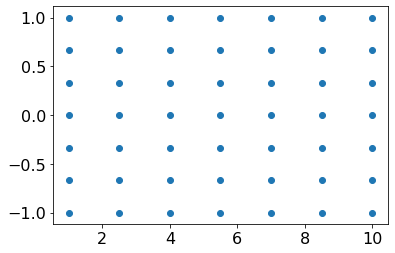

In [278]:
plt.figure()
plt.scatter(sur.grb.greedy_points[:,0], sur.grb.greedy_points[:,1])

In [279]:
# check seed basis and add points
_, ts, ts_coords = gen_2d_massratio_data(
    np.random.uniform(1,10,1000),
    np.random.uniform(-1,1,1000),
    100)
sur.run_greedy_sweep(ts, ts_coords, greedy_tol=1e-4)

tolerance reached. exiting


In [280]:
# build eim
# eim needs to be built from training_set at the greedy points
_, ts, ts_coords = gen_2d_massratio_data(
    sur.grb.greedy_points[:,0],
    sur.grb.greedy_points[:,1],
    100)

In [281]:
sur.build_eim(ts)

In [282]:
# # dev 2d fit
# logq = np.log(sur.grb.greedy_points[:,0])
# chi = sur.grb.greedy_points[:,1]

# x_to_fit = np.column_stack([[logq, chi]]).T

# eim_y = sur.grb.eim.data[0]

In [283]:
# fit_eim
solver=george.HODLRSolver
# solver=george.BasicSolver
sur.fit_eim_2d(solver=solver, verbose=False)

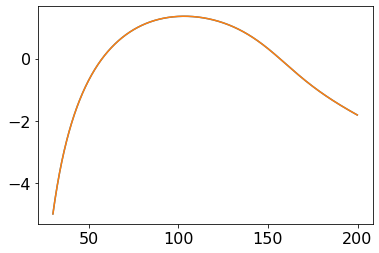

In [284]:
plt.figure()
plt.plot(x, ts[0])
plt.plot(x, sur.predict_2d(*ts_coords[0]))

In [285]:
sur.grb.nbasis

49

In [286]:
# iteratively add points by testing the model

err_tol = 0.02
max_iter = 20

for i in range(max_iter):
    print(i)

    _, vts, vts_coords = gen_2d_massratio_data(
        np.random.uniform(1,10,100),
        np.random.uniform(-1,1,100),
        100)
    
    model_errors, worst_case, worst_error_index = sur.validate_surrogate_2d(vts, vts_coords)
    err = model_errors[worst_error_index]
    print(f"worst error = {err}")
    print(f"worst case = {worst_case}")
    
    
    if err <= err_tol:
        print("stopping")
        break
    else:
        # add the worst case to the basis and re-fit
        vts_worst = vts[worst_error_index]
        vts_coords_worst = vts_coords[worst_error_index]
        sur.run_greedy_sweep(vts_worst.reshape(1,-1), vts_coords_worst.reshape(1, -1), greedy_tol=1e-15)
        # build eim
        # eim needs to be built from training_set at the greedy points
        _, ts, _ = gen_2d_massratio_data(
            sur.grb.greedy_points[:,0],
            sur.grb.greedy_points[:,1],
            100)
        sur.build_eim(ts)
        # fit_eim
        solver=george.HODLRSolver
        # solver=george.BasicSolver
        sur.fit_eim_2d(solver=solver, verbose=False)


0
worst error = 1.599250003959296
worst case = [9.43217993 0.82385791]
step = 0, error = 2.946445111645154e-07
1
worst error = 1.084017837530915
worst case = [2.36923795 0.89769579]
step = 0, error = 1.5713775840155588e-08
2
worst error = 0.3699490013853203
worst case = [ 8.22887034 -0.85067793]
step = 0, error = 5.751332224722866e-10
3
worst error = 0.2878165974248121
worst case = [ 1.29885711 -0.81253023]
step = 0, error = 3.7173973474710855e-11
4
worst error = 0.25111835620433404
worst case = [1.45411682 0.33792515]
step = 0, error = 3.719994270840608e-12
5
worst error = 0.22157187020827912
worst case = [4.2934486  0.90554419]
step = 0, error = 2.1906560237586092e-08
6
worst error = 0.2270539932991208
worst case = [9.34449472 0.5431604 ]
step = 0, error = 4.014590404553824e-09
7
worst error = 0.5388130657529792
worst case = [3.72814882 0.16295449]
step = 0, error = 2.9229680725160364e-11
8
worst error = 0.20588158603920995
worst case = [ 1.1448768  -0.51244836]
step = 0, error = 8.9

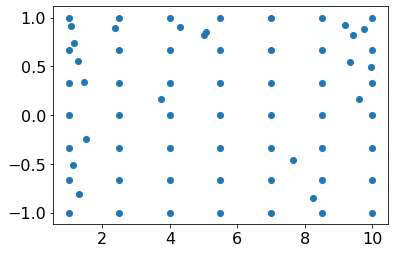

In [287]:
plt.figure()
plt.scatter(sur.grb.greedy_points[:,0], sur.grb.greedy_points[:,1])

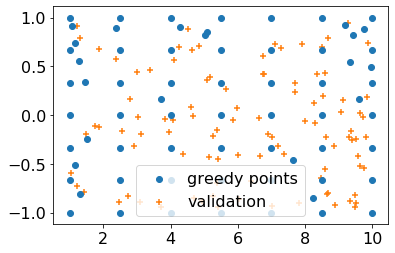

In [288]:
plt.figure()
plt.scatter(sur.grb.greedy_points[:,0], sur.grb.greedy_points[:,1], label='greedy points')
plt.scatter(vts_coords[:,0], vts_coords[:,1], marker='+', label='validation', zorder=-1)
plt.legend()

In [289]:
sur.grb.greedy_points

array([[ 1.        , -1.        ],
       [ 2.5       , -1.        ],
       [ 4.        , -1.        ],
       [ 5.5       , -1.        ],
       [ 7.        , -1.        ],
       [ 8.5       , -1.        ],
       [10.        , -1.        ],
       [ 1.        , -0.66666667],
       [ 2.5       , -0.66666667],
       [ 4.        , -0.66666667],
       [ 5.5       , -0.66666667],
       [ 7.        , -0.66666667],
       [ 8.5       , -0.66666667],
       [10.        , -0.66666667],
       [ 1.        , -0.33333333],
       [ 2.5       , -0.33333333],
       [ 4.        , -0.33333333],
       [ 5.5       , -0.33333333],
       [ 7.        , -0.33333333],
       [ 8.5       , -0.33333333],
       [10.        , -0.33333333],
       [ 1.        ,  0.        ],
       [ 2.5       ,  0.        ],
       [ 4.        ,  0.        ],
       [ 5.5       ,  0.        ],
       [ 7.        ,  0.        ],
       [ 8.5       ,  0.        ],
       [10.        ,  0.        ],
       [ 1.        ,

In [290]:
sur.grb.nbasis

69

In [291]:
_, vts, vts_coords = gen_2d_massratio_data(
    np.random.uniform(1,10,1000),
    np.random.uniform(-1,1,1000),
    100)

In [292]:
np.array([[1,1]]).shape

(1, 2)

In [293]:
len(vts_coords)

1000

In [294]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate_2d(vts, vts_coords)
print(f"worst error = {model_errors[worst_error_index]}")
print(f"worst case = {worst_case}")

worst error = 0.05302675794624183
worst case = [9.84006269 0.86819302]


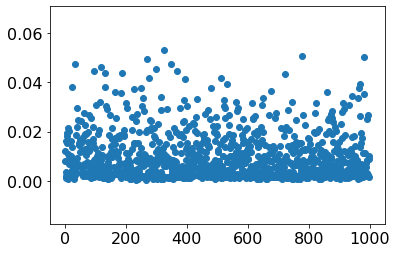

In [295]:
plt.figure()
plt.scatter(range(len(vts_coords)), model_errors)

In [296]:
ts_coords[0]

array([ 1., -1.])

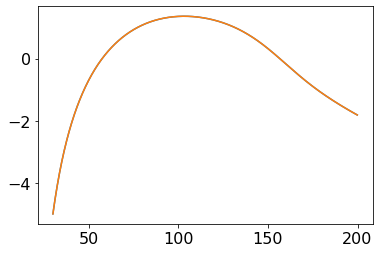

In [297]:
plt.figure()
plt.plot(x, ts[0])
plt.plot(x, sur.predict_2d(*ts_coords[0]))

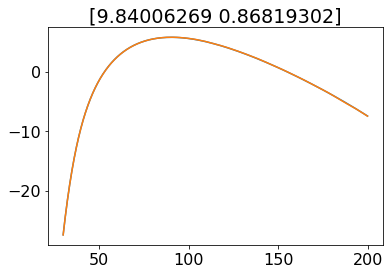

In [298]:
plt.figure()
plt.plot(x, vts[worst_error_index])
plt.plot(x, sur.predict_2d(*vts_coords[worst_error_index]))
plt.title(vts_coords[worst_error_index])
plt.show()
plt.close()

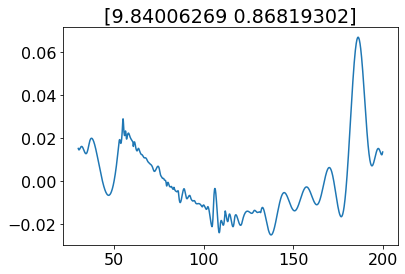

In [299]:
plt.figure()
plt.plot(x, vts[worst_error_index] - sur.predict_2d(*vts_coords[worst_error_index]))
plt.title(vts_coords[worst_error_index])
plt.show()
plt.close()

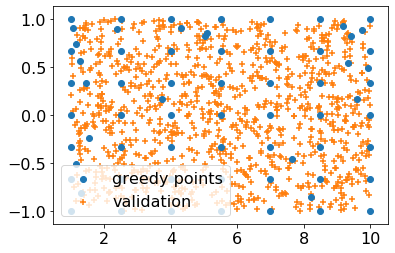

In [300]:
plt.figure()
plt.scatter(sur.grb.greedy_points[:,0], sur.grb.greedy_points[:,1], label='greedy points')
plt.scatter(vts_coords[:,0], vts_coords[:,1], marker='+', label='validation', zorder=-1)
plt.legend()

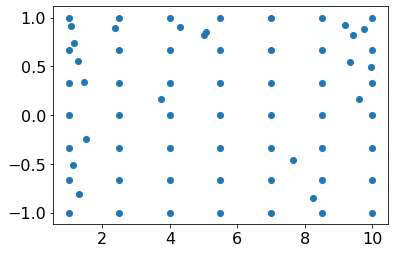

In [301]:
plt.figure()
plt.scatter(sur.grb.greedy_points[:,0], sur.grb.greedy_points[:,1])